In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input


In [3]:
# Load data
df = pd.read_csv(
    'household_power_consumption.txt',
    sep=';',
    na_values='?',
    low_memory=False
)

# Combine Date and Time into one datetime column
df['datetime'] = pd.to_datetime(
    df['Date'] + ' ' + df['Time'],
    format='%d/%m/%Y %H:%M:%S',
    dayfirst=True
)

# Drop the original Date and Time columns
df.drop(columns=['Date', 'Time'], inplace=True)

# Drop rows with missing values
df.dropna(inplace=True)


In [5]:
# Optional: Use subset for faster demo
df = df.iloc[:100000]

# Feature engineering
df['hour'] = df['datetime'].dt.hour
df['usage'] = df['Global_active_power'].astype(float)

# Simulated temperature (not real data)
np.random.seed(42)
df['temperature'] = 20 + 10 * np.sin(2 * np.pi * df['hour'] / 24) + np.random.randn(len(df))


In [7]:
# Prepare inputs and target
X = df[['hour', 'temperature', 'usage']].values[:-1]
y = df['usage'].values[1:]  # Predict next hour's usage

# Standardize input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


In [9]:
# Model builder
def build_model(activation):
    model = Sequential([
        Input(shape=(3,)),
        Dense(64, activation=activation),
        Dense(32, activation=activation),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


In [11]:
# Train with different activations
activations = ['relu', 'tanh', 'sigmoid']
histories = {}

for act in activations:
    print(f"\nTraining model with {act} activation...")
    model = build_model(act)
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=20,
        batch_size=32,
        verbose=0
    )
    histories[act] = history



Training model with relu activation...

Training model with tanh activation...

Training model with sigmoid activation...


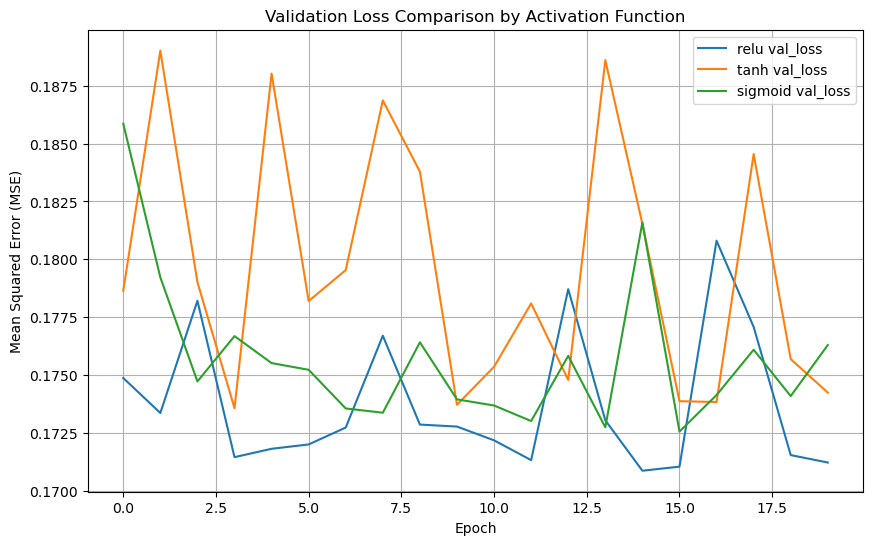

In [13]:
# Compare validation loss
plt.figure(figsize=(10, 6))
for act in activations:
    plt.plot(histories[act].history['val_loss'], label=f'{act} val_loss')
plt.title('Validation Loss Comparison by Activation Function')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
# Final test evaluation
for act in activations:
    print(f"\nEvaluating model with {act} activation on test data:")
    model = build_model(act)
    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)
    loss, mae = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test MSE: {loss:.4f} | Test MAE: {mae:.4f}")



Evaluating model with relu activation on test data:
Test MSE: 0.1569 | Test MAE: 0.1719

Evaluating model with tanh activation on test data:
Test MSE: 0.1646 | Test MAE: 0.1813

Evaluating model with sigmoid activation on test data:
Test MSE: 0.1587 | Test MAE: 0.1797
